In [1]:
%matplotlib inline
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import lmfit
plt.style.use("ggplot")

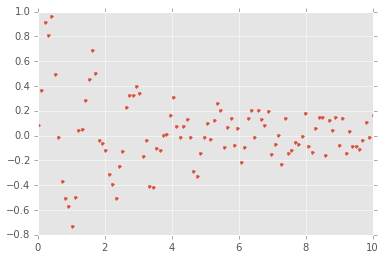

In [2]:
# Generate data
x = np.linspace(0, 10, 100)
y = np.sin(5*x)*np.exp(-x/2.5)
y += npr.choice([-1, 1], size=y.shape)*npr.random(size=y.shape)/5
plt.plot(x, y, '.')
plt.savefig("../img/lmfit/data.svg", bbox_inches="tight")

In [3]:
# Create the model and guess parameters
model = lmfit.models.ExpressionModel("ampl * sin((x - x0)*freq) * exp(-x/tau) + offset")
params = model.make_params(ampl=1, x0=0, freq=10, tau=1, offset=0)
params["offset"].set(vary=False)

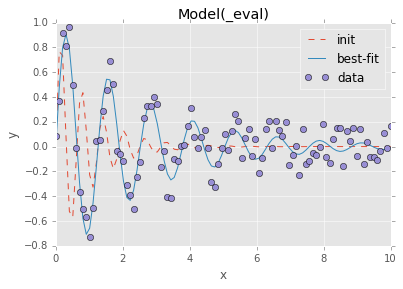

In [4]:
# Fit and visually inspect
fit = model.fit(y, params, x=x)
fit.plot_fit()
plt.savefig("../img/lmfit/fit-expression-model.svg", bbox_inches="tight")

In [5]:
print(fit.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 122
    # data points      = 100
    # variables        = 4
    chi-square         = 1.369
    reduced chi-square = 0.014
    Akaike info crit   = -417.018
    Bayesian info crit = -406.598
[[Variables]]
    freq:     4.97964137 +/- 0.034454 (0.69%) (init= 10)
    tau:      2.60560348 +/- 0.246606 (9.46%) (init= 1)
    offset:   0 (fixed)
    ampl:     1.02045744 +/- 0.068242 (6.69%) (init= 1)
    x0:       0.00020489 +/- 0.012188 (5948.74%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(tau, ampl)                 = -0.720 
    C(freq, x0)                  =  0.681 
    C(ampl, x0)                  =  0.129 



In [6]:
# Example of model subclassing for better reusability

class DecayingSineModel(lmfit.Model):
    def __init__(self, *args, **kwargs):
        def decaying_sine(x, ampl, offset, freq, x0, tau):
            return ampl * np.sin((x - x0)*freq) * np.exp(-x/tau) + offset
        super(DecayingSineModel, self).__init__(decaying_sine, *args, **kwargs)
    
    def guess(self, data, **kwargs):         
        params = self.make_params()
        def pset(param, value):
            params["%s%s" % (self.prefix, param)].set(value=value)
        pset("ampl", np.max(data) - np.min(data))
        pset("offset", np.mean(data))
        pset("freq", 1)
        pset("x0", 0)
        pset("tau", 1)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

In [7]:
model = DecayingSineModel()
params = model.guess(y, x=x)
fit = model.fit(y, params, x=x)

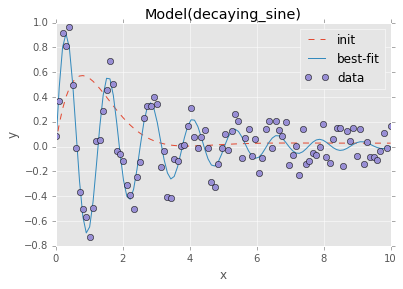

In [8]:
fit.plot_fit()
plt.savefig("../img/lmfit/fit-decaying-sine-model.svg", bbox_inches="tight")

In [9]:
print(fit.fit_report())

[[Model]]
    Model(decaying_sine)
[[Fit Statistics]]
    # function evals   = 152
    # data points      = 100
    # variables        = 5
    chi-square         = 1.362
    reduced chi-square = 0.014
    Akaike info crit   = -414.513
    Bayesian info crit = -401.488
[[Variables]]
    ampl:     1.01509806 +/- 0.068642 (6.76%) (init= 1.690452)
    offset:   0.00866496 +/- 0.012058 (139.16%) (init= 0.02785899)
    freq:     4.98055762 +/- 0.034458 (0.69%) (init= 1)
    x0:       0.00051399 +/- 0.012254 (2384.24%) (init= 0)
    tau:      2.62045162 +/- 0.250289 (9.55%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(ampl, tau)                 = -0.722 
    C(freq, x0)                  =  0.681 
    C(ampl, x0)                  =  0.124 
    C(ampl, offset)              = -0.110 



In [10]:
# Show all parameters and standard error estimates
for key in fit.params:
    print(key, "=", fit.params[key].value, "+/-", fit.params[key].stderr)

ampl = 1.01509805981 +/- 0.0686424802112
offset = 0.00866496750688 +/- 0.0120582675657
freq = 4.98055762006 +/- 0.0344587866965
x0 = 0.00051399773059 +/- 0.0122549465211
tau = 2.62045162933 +/- 0.250289489618
